In [69]:
import librosa
import numpy as np
import soundfile as sf
from IPython.display import Audio
from scipy.signal import fftconvolve
import scipy

# Load original sweep (mono)
sweep, sr = librosa.load('Sine_sweep_single.wav', sr=None, mono=True)

# Load recorded response (stereo BRIR)
recorded, _ = librosa.load('Binaural_impulse.wav', sr=None, mono=False)



In [71]:
#Vanilla Deconvolution
def create_inverse_sweep(sweep):
    # Time-reverse the sweep
    inverse = sweep[::-1]
    
    # Apply amplitude envelope correction for log sweeps
    t = np.arange(len(sweep))
    envelope = np.exp(-t / len(t) * np.log(sweep.shape[0]))
    
    # Apply the envelope to the time-reversed sweep
    inverse = inverse * envelope
    
    return inverse
    
inverse = create_inverse_sweep(sweep)

# Convolve each channel of the recorded response with the inverse sweep
ir_left = fftconvolve(recorded[0], inverse, mode='full')
ir_right = fftconvolve(recorded[1], inverse, mode='full')

# Stack as stereo BRIR
brir = np.vstack((ir_left, ir_right))


In [6]:
##Attempt Toeplitz Deconvolution

##inverse_sweep = sweep[::-1]
##r = np.real(fftconvolve(sweep, inverse_sweep, mode='full'))
##length_limit = 2000 # something reasonable so R fits in memory 
                     # and inverting it doesn't take ages
##r = r[len(r)//2: len(r)//2 + length_limit]
##R = scipy.linalg.toeplitz(r)
##R_i = scipy.linalg.pinv(R)
##w_l = R_i @ brir_left_trimmed[0:length_limit]
##w_r = R_i @ brir_right_trimmed[0:length_limit]

NameError: name 'brir_left_trimmed' is not defined

In [72]:
##t = np.arange(len(w_l)) / sr

##plt.figure(figsize=(12, 4))
##plt.plot(t, w_l, label='Left IR')
##plt.plot(t, w_r, label='Right IR', alpha=0.7)
##plt.title('Impulse Response Estimated via Toeplitz Deconvolution')
##plt.xlabel('Time (s)')
##plt.ylabel('Amplitude')
##plt.legend()
##plt.grid(True)
##plt.tight_layout()
##plt.show()

NameError: name 'w_l' is not defined

In [73]:
# Normalize to prevent clipping
brir /= np.max(np.abs(brir))

# Save result
sf.write('deconvolved_brir.wav', brir.T, sr)


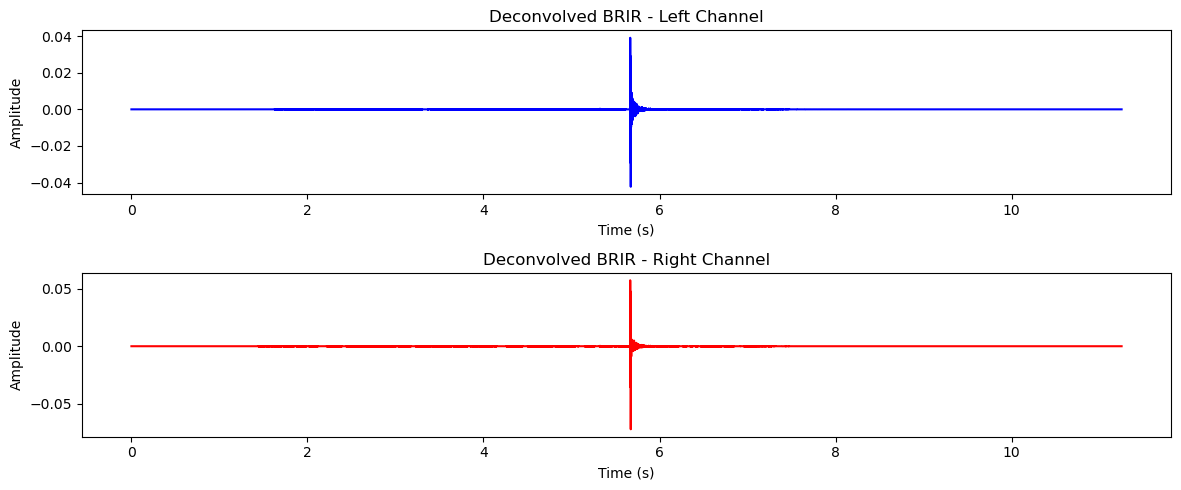

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Time axis (in seconds)
t = np.arange(len(ir_left)) / sr

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(t, ir_left, color='blue')
plt.title("Deconvolved BRIR - Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
 
plt.subplot(2, 1, 2)
plt.plot(t, ir_right, color='red')
plt.title("Deconvolved BRIR - Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [75]:
# Find the peak of the impulse response
peak_index_left = np.argmax(np.abs(ir_left))
peak_index_right = np.argmax(np.abs(ir_right))

# Trim to keep only the useful part keep 100 samples before peak and the rest after peak
pre_samples = 100
ir_left_trimmed = ir_left[peak_index_left-pre_samples:]
ir_right_trimmed = ir_right[peak_index_right-pre_samples:]

# Make sure both channels have the same length
min_length = min(len(ir_left_trimmed), len(ir_right_trimmed))
ir_left_trimmed = ir_left_trimmed[:min_length]
ir_right_trimmed = ir_right_trimmed[:min_length]

# Create the final trimmed BRIR
brir_trimmed = np.vstack((ir_left_trimmed, ir_right_trimmed))

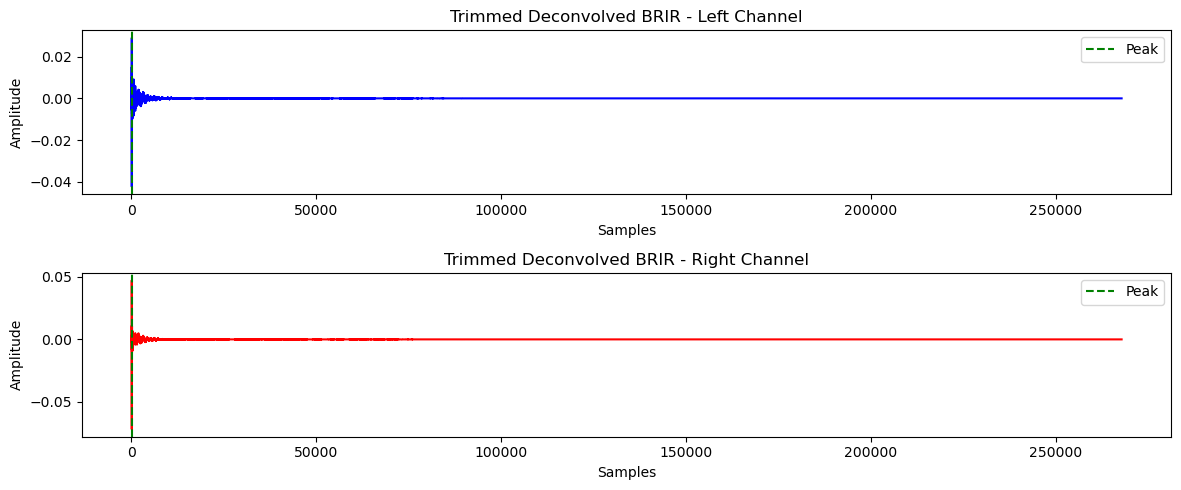

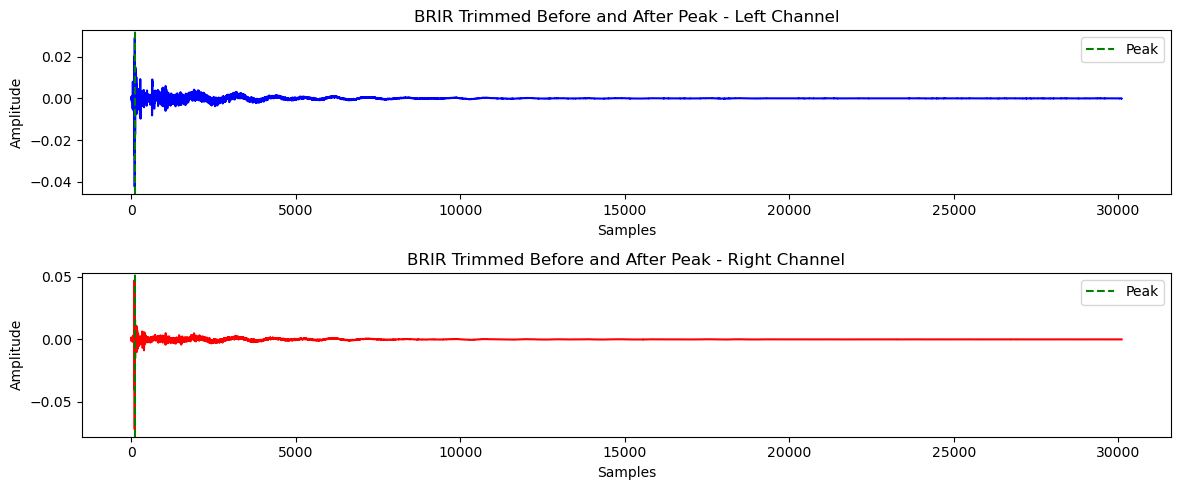

In [76]:
# Find the peak of the impulse response
peak_index_left = np.argmax(np.abs(ir_left))
peak_index_right = np.argmax(np.abs(ir_right))

# Trim to keep only the useful part keep 100 samples before peak
pre_samples = 100
ir_left_trimmed = ir_left[peak_index_left-pre_samples:]
ir_right_trimmed = ir_right[peak_index_right-pre_samples:]

# Make sure both channels have the same length
min_length = min(len(ir_left_trimmed), len(ir_right_trimmed))
ir_left_trimmed = ir_left_trimmed[:min_length]
ir_right_trimmed = ir_right_trimmed[:min_length]

# Create the final trimmed BRIR
brir_trimmed = np.vstack((ir_left_trimmed, ir_right_trimmed))

# Sample indices for x-axis
samples = np.arange(min_length)

# Plot the trimmed BRIR with samples on x-axis
plt.figure(figsize=(12, 5))

# Plot Left Channel (trimmed)
plt.subplot(2, 1, 1)
plt.plot(samples, ir_left_trimmed, color='blue')
plt.title("Trimmed Deconvolved BRIR - Left Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
# Add a vertical line at sample 100 (pre_samples) to mark the peak
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

# Plot Right Channel (trimmed)
plt.subplot(2, 1, 2)
plt.plot(samples, ir_right_trimmed, color='red')
plt.title("Trimmed Deconvolved BRIR - Right Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
# Add a vertical line at sample 100 (pre_samples) to mark the peak
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.tight_layout()
plt.show()

#Trim after the peak
post_samples = 30000  # keep 5000 samples after the peak
ir_left_trimmed_both = ir_left[peak_index_left-pre_samples:peak_index_left+post_samples]
ir_right_trimmed_both = ir_right[peak_index_right-pre_samples:peak_index_right+post_samples]

# Make sure both channels have the same length
min_length_both = min(len(ir_left_trimmed_both), len(ir_right_trimmed_both))
ir_left_trimmed_both = ir_left_trimmed_both[:min_length_both]
ir_right_trimmed_both = ir_right_trimmed_both[:min_length_both]

# Create the final trimmed BRIR (trimmed both before and after peak)
brir_trimmed_both = np.column_stack((ir_left_trimmed_both, ir_right_trimmed_both))

# Plot with samples on x-axis for the version trimmed on both sides
samples_both = np.arange(min_length_both)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(samples_both, ir_left_trimmed_both, color='blue')
plt.title("BRIR Trimmed Before and After Peak - Left Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(samples_both, ir_right_trimmed_both, color='red')
plt.title("BRIR Trimmed Before and After Peak - Right Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.tight_layout()
plt.show()

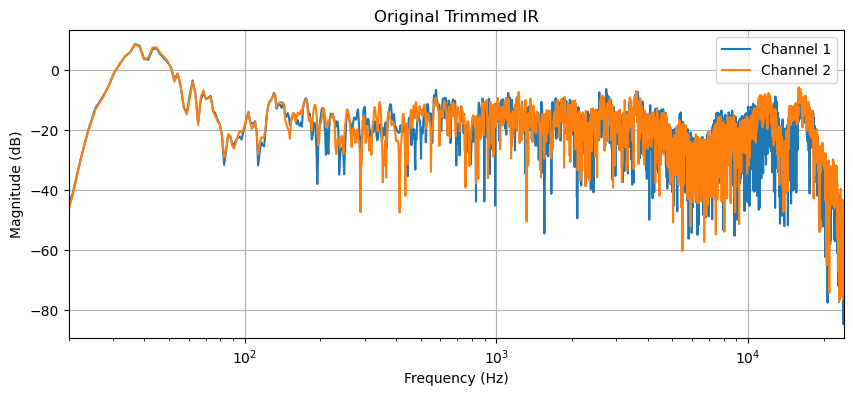

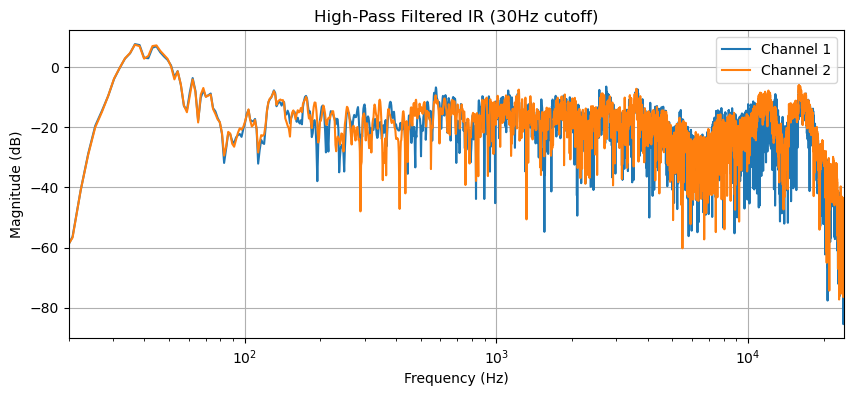

High-pass filtering complete with 30Hz cutoff


In [77]:
from scipy.signal import butter, sosfilt

sample_rate = sr

# Check the shape of the impulse response
if len(brir_trimmed_both.shape) == 1:
    print("Warning: Input is mono, converting to stereo")
elif len(brir_trimmed_both.shape) > 2:
    # If it's a 3D array (common for multi-channel IRs), reshape as needed
    print(f"Input shape: {brir_trimmed_both.shape}, reshaping if needed")
    if brir_trimmed_both.shape[0] == 2:  # If first dimension is channels
        brir_trimmed_both = brir_trimmed_both.T  # Transpose to samples x channels

# Design a high-pass filter
cutoff_freq = 30  # Example: 100 Hz cutoff - adjust as needed
nyquist = sample_rate / 2
normalized_cutoff = cutoff_freq / nyquist
order = 4  # Filter order

# Using second-order sections for better numerical stability
sos = butter(order, normalized_cutoff, btype='highpass', output='sos')

# Apply the filter to each channel
if len(brir_trimmed_both.shape) == 1:
    # For mono
    brir_highpassed = sosfilt(sos, brir_trimmed_both)
else:
    # For stereo or multi-channel
    brir_highpassed = np.zeros_like(brir_trimmed_both)
    for channel in range(brir_trimmed_both.shape[1]):
        brir_highpassed[:, channel] = sosfilt(sos, brir_trimmed_both[:, channel])

# Optional: Visualize the frequency response before and after filtering
def plot_spectrum(signal, fs, title):
    plt.figure(figsize=(10, 4))
    if len(signal.shape) == 1:  # Mono
        spectrum = np.abs(np.fft.rfft(signal))
        freqs = np.fft.rfftfreq(len(signal), 1/fs)
        plt.semilogx(freqs, 20 * np.log10(spectrum + 1e-10))
    else:  # Stereo or multi-channel
        for channel in range(signal.shape[1]):
            spectrum = np.abs(np.fft.rfft(signal[:, channel]))
            freqs = np.fft.rfftfreq(len(signal[:, channel]), 1/fs)
            plt.semilogx(freqs, 20 * np.log10(spectrum + 1e-10), 
                         label=f'Channel {channel+1}')
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.xlim(20, fs/2)
    if signal.shape[1] > 1:
        plt.legend()
    plt.show()

# Plot original and filtered spectra
plot_spectrum(brir_trimmed_both, sample_rate, 'Original Trimmed IR')
plot_spectrum(brir_highpassed, sample_rate, f'High-Pass Filtered IR ({cutoff_freq}Hz cutoff)')

print(f"High-pass filtering complete with {cutoff_freq}Hz cutoff")

# Now brir_highpassed contains your high-pass filtered stereo impulse response

In [78]:
sf.write('brir_trimmed.wav', brir_highpassed, sample_rate)
print("BRIR saved as WAV using soundfile")


BRIR saved as WAV using soundfile


In [79]:
# Load mono dry input audio
audio, sr = librosa.load('majula.wav', sr=48000, mono=True)
# Note: audio is now a 1D array since mono=True

# Use the already created brir_trimmed_both variable
# Transpose to get shape (2, n_samples) for convolution
brir = brir_trimmed_both.T  # Now shape is (2, n_samples)

# Since audio is mono (1D), we can directly convolve it with each channel of the BRIR
# Assuming brir_highpassed is what you meant to use instead of brir
# If brir_highpassed isn't defined, replace with brir in the lines below
wet_left = fftconvolve(audio, brir[0], mode='full')   # Convolve mono audio with left channel
wet_right = fftconvolve(audio, brir[1], mode='full')  # Convolve mono audio with right channel

# Combine into proper shape (n_samples, n_channels)
wet = np.column_stack((wet_left, wet_right))

# Normalize
wet = wet / np.max(np.abs(wet))

# Save to file
sf.write('convolved_majula.wav', wet, sr)

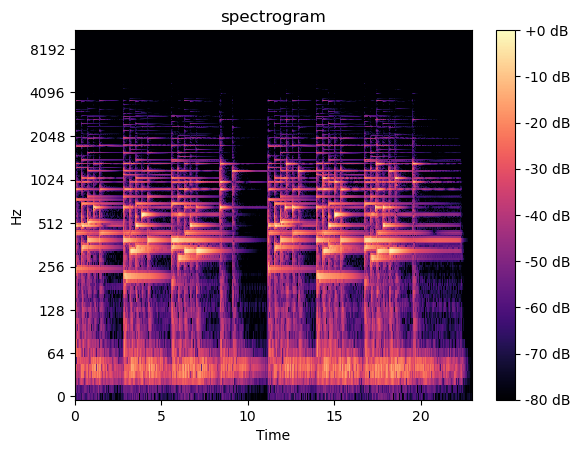

In [80]:
y, sr = librosa.load('convolved_majula.wav')

#compute the STFT
S = np.abs(librosa.stft(y))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [81]:
Audio('convolved_majula.wav', rate=sr)